# Taller 5: Modelos predictivos para hacer inferencia sobre el comportamiento futuro de la red

# Punto 1

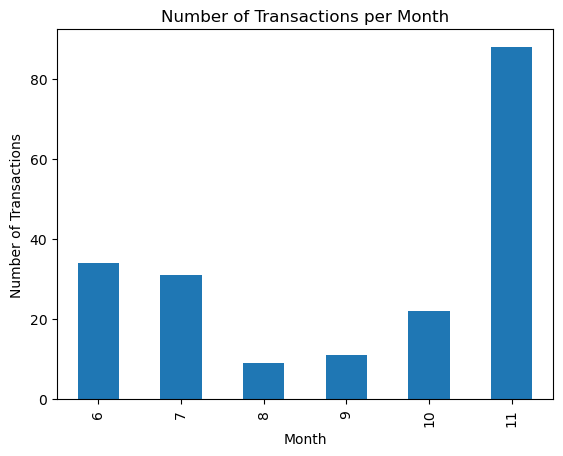

In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict

# Cargar datos
data = pd.read_csv('network_data.csv')

# Convertir a datetime
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%y')
data['month'] = data['date'].dt.month

# Calcular transacciones por mes
promedio_transacciones = data.groupby('month').size()

# Crear un grafo con la información hasta el i-ésimo mes
graph_by_month = OrderedDict()
for month in range(6,12):
    graph = nx.from_pandas_edgelist(data[data['month'] <= month], 'source', 'target', create_using=nx.Graph)
    graph_by_month[month] = graph
    
# Mostrar número de transacciones por mes
promedio_transacciones.plot(
    kind='bar', 
    xlabel='Month', 
    ylabel='Number of Transactions', 
    title='Number of Transactions per Month',
);

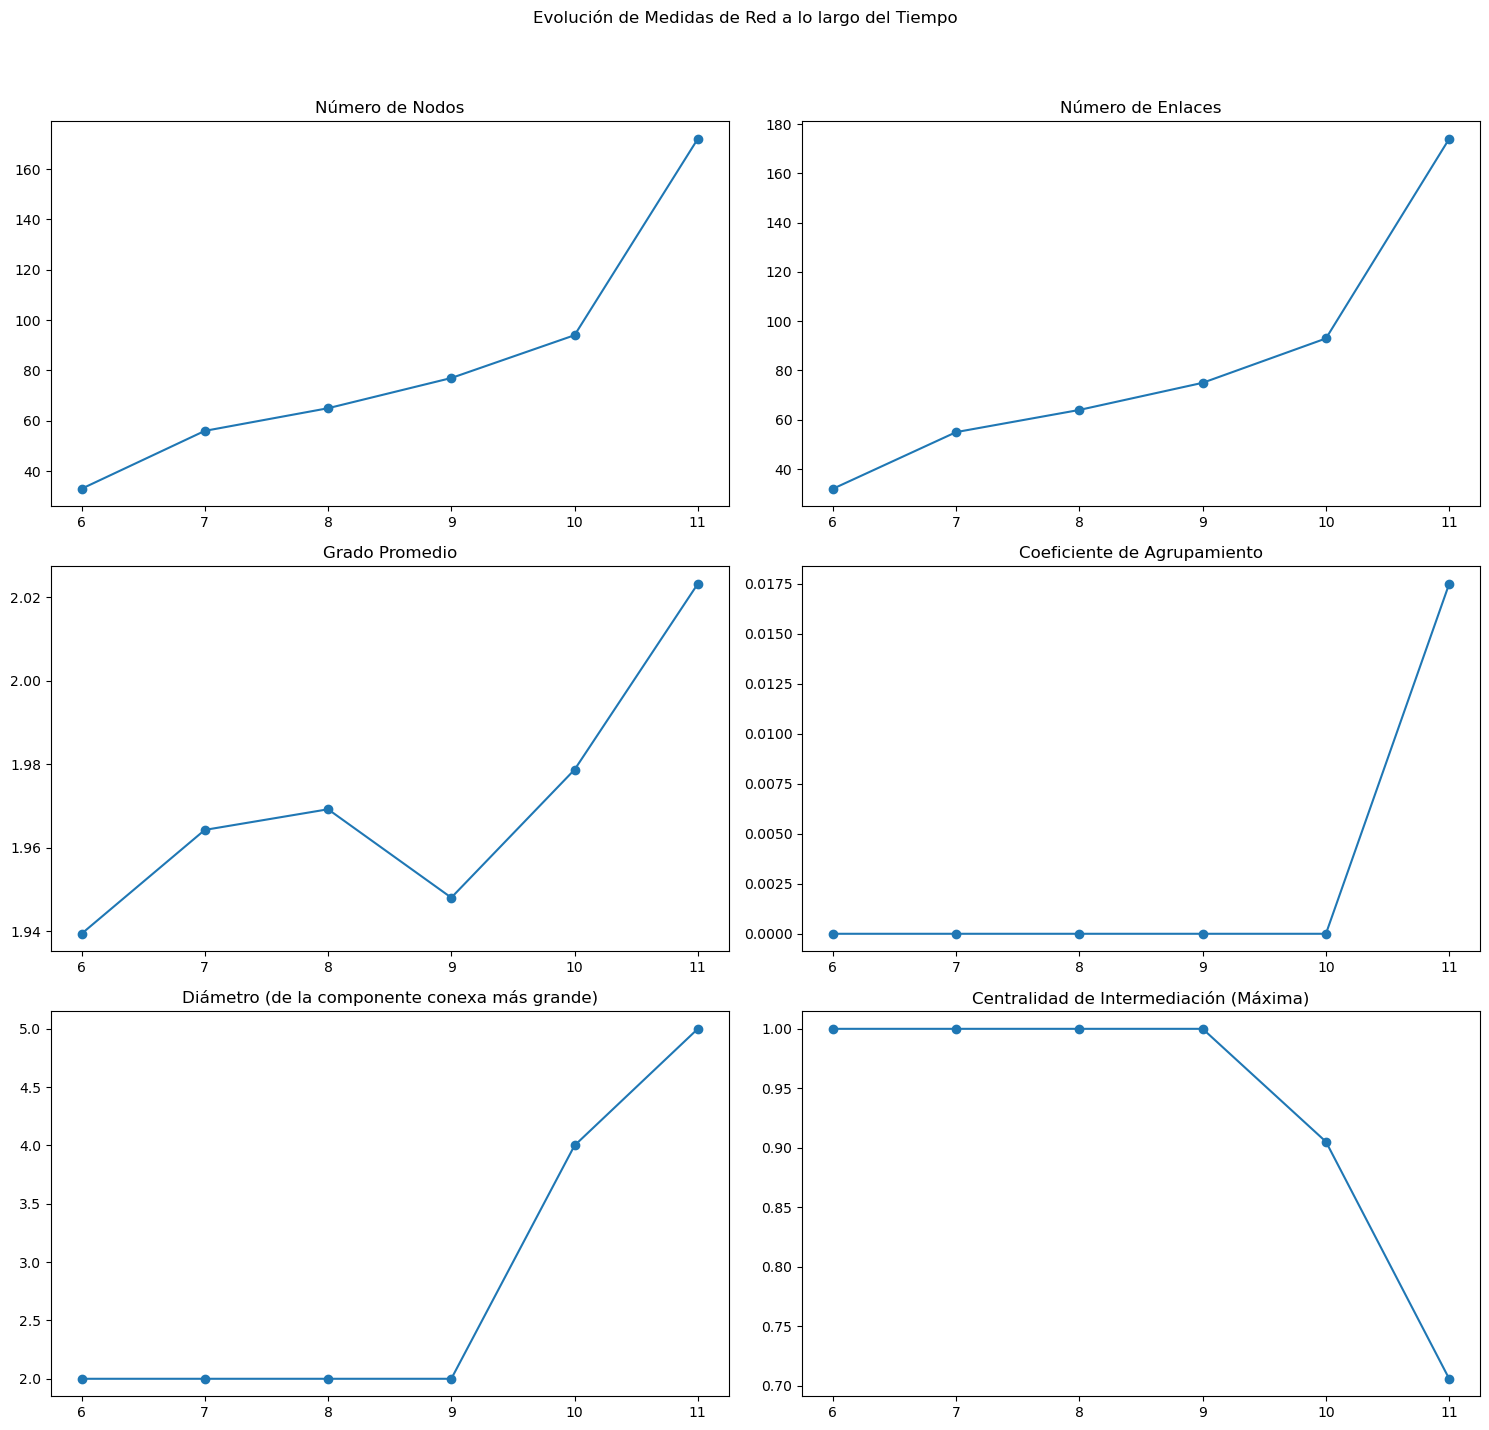

In [94]:
# Inicializar listas para almacenar resultados por mes
num_nodos = []
num_enlaces = []
grado_promedio = []
coef_agrupamiento = []
diametro = []
intermediacion = []
cercania = []

# Calcular medidas de red para cada mes
for month in range(6, 12):
    subgraph = graph_by_month[month]  # Obtener el grafo del mes específico
    
    num_nodos.append(subgraph.number_of_nodes())
    num_enlaces.append(subgraph.number_of_edges())
    
    # Calcular el grado promedio
    grado_promedio.append(sum(dict(subgraph.degree()).values()) / len(subgraph))
    
    coef_agrupamiento.append(nx.average_clustering(subgraph))
    
    # Calcular el diámetro solo para la componente conexa más grande
    largest_connected_component = max(nx.connected_components(subgraph), key=len)
    largest_subgraph = subgraph.subgraph(largest_connected_component)
    diametro.append(nx.diameter(largest_subgraph))
    
    # Calcular la centralidad de intermediación
    intermediacion.append(dict(nx.betweenness_centrality(largest_subgraph)))
    
    # Calcular la centralidad de cercanía
    cercania.append(dict(nx.closeness_centrality(largest_subgraph)))

# Graficar las medidas a lo largo del tiempo
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Evolución de Medidas de Red a lo largo del Tiempo')

axs[0, 0].plot(range(6, 12), num_nodos, marker='o')
axs[0, 0].set_title('Número de Nodos')

axs[0, 1].plot(range(6, 12), num_enlaces, marker='o')
axs[0, 1].set_title('Número de Enlaces')

axs[1, 0].plot(range(6, 12), grado_promedio, marker='o')
axs[1, 0].set_title('Grado Promedio')

axs[1, 1].plot(range(6, 12), coef_agrupamiento, marker='o')
axs[1, 1].set_title('Coeficiente de Agrupamiento')

axs[2, 0].plot(range(6, 12), diametro, marker='o')
axs[2, 0].set_title('Diámetro (de la componente conexa más grande)')

axs[2, 1].plot(range(6, 12), [max(i.values()) for i in intermediacion], marker='o')
axs[2, 1].set_title('Centralidad de Intermediación (Máxima)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Número de Nodos y Enlaces:**

Un aumento en el número de nodos podría indicar un crecimiento en la cantidad de participantes en el mercado de criptomonedas. Esto podría ser una oportunidad para "Crypto Club" expandir su base de clientes, pero también podría aumentar la competencia.

---

**Grado Promedio:**

Un incremento en el grado promedio sugiere una mayor interconexión entre las billeteras de los usuarios. Esto podría indicar una mayor actividad y transacciones entre los clientes de "Crypto Club", lo que es esencial para comprender las dinámicas del mercado. Aunque en el periodo 9 bajó, en el siguiente mes comenzó a incrementar.

**Coeficiente de Agrupamiento:**

Cambios en el coeficiente de agrupamiento podrían señalar la formación o disolución de comunidades dentro de la red. Identificar estas comunidades es crucial para entender cómo ciertos grupos de clientes interactúan entre sí. El coeficiente no cambia sino hasta el periodo 10.Este aumento significativo podría indicar una mayor formación de comunidades dentro de la red de transacciones. Esto podría deberse a que ciertos grupos de usuarios tienden a realizar transacciones entre ellos con mayor frecuencia.

"Crypto Club" podría interpretar este aumento como una señal de que ciertos segmentos de su base de clientes están interactuando de manera más intensa. Esto podría ser una oportunidad para adaptar estrategias de marketing específicas para cada comunidad o grupo de usuarios.

Por otro lado, un alto coeficiente de agrupamiento también puede indicar una mayor resistencia al cambio dentro de ciertas comunidades. Si "Crypto Club" busca expandirse y atraer nuevos clientes, podría enfrentar desafíos al intentar penetrar en estas comunidades más cerradas.

---

**Diámetro:**

Un aumento en el diámetro podría indicar una mayor dispersión de las transacciones en la red. Esto podría tener implicaciones para la velocidad de propagación de información o transacciones, lo cual es vital en un mercado volátil como el de las criptomonedas. Este aumenta del periodo 9-11.

---

**Centralidad de Intermediación:**

Se observa que la centralidad de intermediación ha disminuido por dos periodos consecutivos ,esto podría deberse a una disminución en el número de transacciones que pasa por ese nodo, lo que indica una posible reducción en su papel de intermediario en la red. Podría haber surgido un nuevo nodo o conjunto de nodos que están asumiendo roles más prominentes en la intermediación de transacciones. Esto podría indicar cambios en la dinámica de la red, con otros actores asumiendo funciones más importantes.

# Punto 2

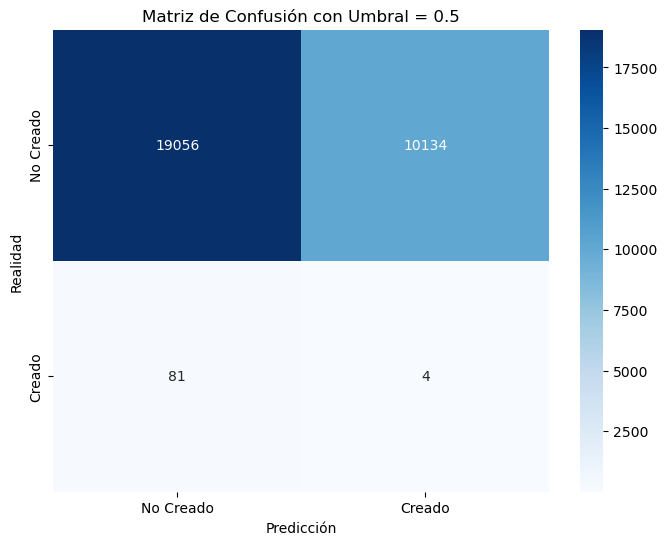

In [87]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Definir un umbral de confianza
threshold = 0.5

# Obtener conjunto de todos los nodos del grafo
all_nodes = set(data['source']) | set(data['target'])

# Crear grafo con datos entre los meses 6 y 10
graph_train = nx.from_pandas_edgelist(data[data['month'].between(6, 10)], 'source', 'target', create_using=nx.Graph)
graph_train.add_nodes_from(all_nodes)

# Crear grafo con datos de noviembre
graph_test = nx.from_pandas_edgelist(data, 'source', 'target', create_using=nx.Graph)

# Calcular índice de Jaccard para posibles conexiones nuevas en el grafo con datos reducidos
jaccard_scores = []
for node_a in graph_train.nodes():
    for node_b in graph_train.nodes():
        if not graph_train.has_edge(node_a, node_b):
            neighbors_a = set(graph_train.neighbors(node_a))
            neighbors_b = set(graph_test.neighbors(node_b))
            jaccard_index = len(neighbors_a.intersection(neighbors_b)) / len(neighbors_a.union(neighbors_b))
            node_a, node_b = min(node_a, node_b), max(node_a, node_b)
            jaccard_scores.append((node_a, node_b, jaccard_index))

# Obtener información sobre la existencia de conexiones en el grafo completo
existing_edges = {(min(node_a, node_b), max(node_a, node_b)) for node_a, node_b in graph_test.edges()}

# Preparar datos
ground_truth = [1 if (node_a, node_b) in existing_edges else 0 for node_a, node_b, _ in jaccard_scores]
predictions = [1 if score >= threshold else 0 for _, _, score in jaccard_scores]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(ground_truth, predictions)

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Creado', 'Creado'], yticklabels=['No Creado', 'Creado'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión con Umbral = {}'.format(threshold))
plt.show()

> Los resultados de la predicción basada en vecinos utilizando el índice de Jaccard muestran que este método no es efectivo para la identificación de nuevos enlaces. El motivo principal radica en que los nuevos enlaces que se forman tienen la característica de ser principalmente enlaces con nuevos nodos que no estaban previamente en la red. Por tanto, no es útil utilizar información de vecinos ya que esta asume que la conexión se generará entre dos nodos existentes en la red.

# Punto 3

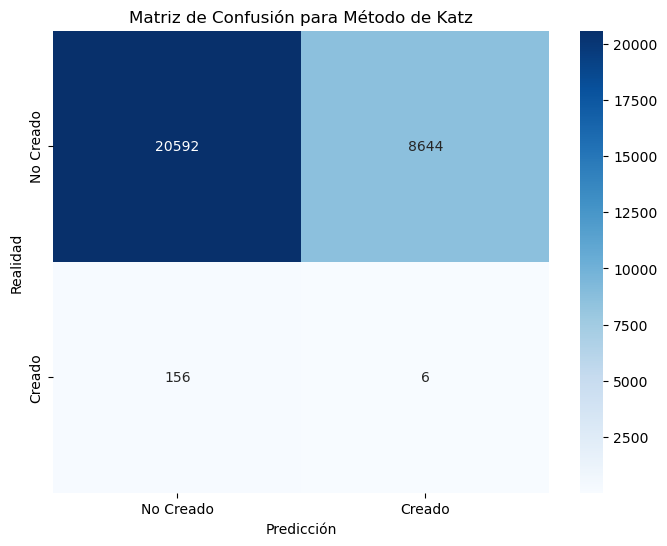

In [93]:
import numpy as np
from scipy.linalg import inv

# Parámetro beta para la medida de Katz
beta = 0.1

# Definir un umbral de Katz
threshold = 0.5

# Obtener conjunto de todos los nodos del grafo
all_nodes = set(data['source']) | set(data['target'])

# Crear grafo con datos entre los meses 6 y 10
graph_train = nx.from_pandas_edgelist(data[data['month'].between(6, 10)], 'source', 'target', create_using=nx.Graph)
graph_train.add_nodes_from(all_nodes)

# Crear grafo con datos de noviembre
graph_test = nx.from_pandas_edgelist(data, 'source', 'target', create_using=nx.Graph)

# Calcular la matriz de adyacencia para el grafo con datos reducidos
A_train = nx.to_numpy_array(graph_train)

# Calcular la medida de Katz
katz_matrix = inv(np.identity(len(graph_train)) - beta * A_train) - np.identity(len(graph_train))

# Obtener información sobre la existencia de conexiones en el grafo completo
existing_edges = {(min(node_a, node_b), max(node_a, node_b)) for node_a, node_b in graph_test.edges()}

# Crear lista de todas las posibles conexiones nuevas en el grafo con datos reducidos
potential_edges = [(min(node_a, node_b), max(node_a, node_b)) for node_a in graph_train.nodes() for node_b in graph_train.nodes() if not graph_train.has_edge(node_a, node_b)]

# Calcular puntuaciones para todas las posibles conexiones nuevas
katz_scores = []
for node_a, node_b in potential_edges:
    
    # Obtener índices correspondientes a los nodos
    index_a, index_b = list(graph_train.nodes()).index(node_a), list(graph_train.nodes()).index(node_b)

    # Obtener puntaje de Katz para la conexión
    katz_score = katz_matrix[index_a, index_b]
    
    # Ajustar el puntaje para darle mayor importancia a los valores cercanos a cero
    adjusted_score = 1 / (1 + np.exp(-katz_score))  # Utilizando la función sigmoide
    
    # Agregar la predicción a la lista
    katz_scores.append((node_a, node_b, adjusted_score))


# Preparar datos
ground_truth = [1 if (node_a, node_b) in existing_edges else 0 for node_a, node_b, _ in katz_scores]
predictions = [1 if score > threshold else 0 for _, _, score in katz_scores]

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(ground_truth, predictions)

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Creado', 'Creado'], yticklabels=['No Creado', 'Creado'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión para Método de Katz')
plt.show()

> Los resultados de la predicción de arcos basada en caminos dieron un mejor resultado que aquella basada en vecinos. A pesar de esto, dicho método sufre del mismo problema que el método anterior al no considerar los nuevos nodos que entran a la red. La mejora radica en una menor cantidad de falsos positivos, si bien también se incrementa la cantidad de falsos negativos.

# Punto 4

1. **Estrategias de Marketing Segmentadas:**

- Corto Plazo: Aprovechar el aumento en el coeficiente de agrupamiento para implementar estrategias de marketing segmentadas. Identificar comunidades específicas dentro de la red y personalizar las campañas de marketing para cada grupo. Esto podría aumentar la participación y la retención de clientes a corto plazo.

- Largo Plazo: Continuar monitoreando las dinámicas de las comunidades y ajustar las estrategias de marketing en consecuencia. Mantener un enfoque flexible para adaptarse a posibles cambios en la estructura de la red y las interacciones entre los usuarios.

2. **Expansión de Servicios:**

- Corto Plazo: Analizar el aumento en el número de nodos como una oportunidad para expandir la oferta de servicios. Introducir nuevas funciones o productos que atraigan a diferentes segmentos de usuarios. Esto podría generar ingresos adicionales y fortalecer la presencia de "Crypto Club".

- Largo Plazo: Estar atento a las tendencias del mercado y a las demandas de los usuarios. Mantener la flexibilidad para adaptar y expandir continuamente los servicios en respuesta a la evolución del mercado de criptomonedas.

3. **Monitoreo Continuo de la Centralidad de Intermediación:**

- Corto Plazo: Investigar la disminución en la centralidad de intermediación. Identificar los nodos que están asumiendo roles más prominentes y evaluar la causa de este cambio. Puede haber oportunidades para colaboraciones estratégicas o asociaciones que fortalezcan la posición de "Crypto Club" en la red.

- Largo Plazo: Implementar un sistema de monitoreo continuo para evaluar la evolución de la centralidad de intermediación. Mantenerse alerta ante cambios en la red y ajustar las estrategias operativas según sea necesario.

4. **Diversificación de la Red:**

- Corto y Largo Plazo: Considerar estrategias para atraer nuevos nodos a la red. Explorar asociaciones con otros actores clave en el mercado de criptomonedas. La diversificación de la red puede proporcionar nuevas oportunidades de colaboración y mejorar la resiliencia frente a cambios en el entorno competitivo.

5. **Evaluación Continua de Métodos de Predicción:**

- Corto y Largo Plazo: Continuar evaluando y mejorando los métodos de predicción utilizados. Dada la naturaleza dinámica del mercado de criptomonedas, es crucial estar al tanto de las limitaciones de los modelos y adoptar enfoques más avanzados a medida que evoluciona la tecnología y la comprensión del comportamiento de la red.